# Exploring Pretrained Features

import necessary libraries

In [9]:
import pickle as pkl
from torchvision import datasets, transforms
from finetune.data import load_dataset
import numpy as np
from sklearn.linear_model import LogisticRegression
import torch
import scipy.signal
import matplotlib.pyplot as plt
import skimage.measure
from sklearn.decomposition import PCA
from torchvision import models
from ipywidgets import interact, widgets
from IPython.display import display
from IPython.display import Image

### Problem overview:
In this problem we will discover just how powerful the learned features from pretrained models really are. We will be comparing the performance of 3 different sets of features. The first is the most naive feature set possible: the set of raw pixel values. For the next feature set, you will augment the set raw pixel values with a set of features extracted from hand designed convolutional filters that you will create. And lastly we will compare these two sets of features to the features extracted from a state of the art pretrained model: Resnet18.

We will be using the CIFAR10 dataset for all parts of this problem. This is an image classification dataset of 32x32 color images that are in one of ten categories: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. Learn more about CIFAR10 here https://www.cs.toronto.edu/~kriz/cifar.html. For the purposes of similicity, in this problem we will only classify between airplanes and automobiles, so this is a binary classification problem.

We will evaulate the three featureizations described above on three different models. First we will train an ridge penalized OLS model, which you learned about in ee16a. Next we will train a logistic regression model, using scikit's implementation of logistic regression. And lastly we will create a logistic regression model in pytorch and train it via gradient descent.

After all of this we will visulize these featurizations by using the PCA dimentionality reducation technique you've learned about in ee16b. Ideally this visualization will give some intuition as to why some featurizations work better than others.

And finally we will look at some of the convolutional filters learned by pretrained models, and compare them to the filters you designed by hand. Ideally this exercise will lead you to appraciate just how nuanced and detailed the features learned by these pretrained models really are.

#### load the data
You don't need to do anything here except run the cell to load the data


In [10]:
labels = {0: 0, 1: 1}
# train_resnet_features and val_resnet_features contain the pretrained features for each image in the dataset
with open('data_ft/train_features.pkl', 'rb') as f:
    train_resnet_features = pkl.load(f)
    train_resnet_features = [item['features'].squeeze() for item in train_resnet_features if item['y'] in labels]
    
with open('data_ft/val_features.pkl', 'rb') as f:
    val_resnet_features = pkl.load(f)
    val_resnet_features = [item['features'].squeeze() for item in val_resnet_features if item['y'] in labels]

# train_images and val_images contain the raw images
train_dataset, val_dataset, label_names = load_dataset('cifar10')
train_images = [x for x, y in train_dataset if y in labels]
val_images = [x for x, y in val_dataset if y in labels]

# train_y and val_y are arrays of the labels for each item in the images and features arrays
y_train = [y for x, y in train_dataset if y in labels]
y_val = [y for x, y in val_dataset if y in labels]

Files already downloaded and verified
Files already downloaded and verified


#### visualize CIFAR 10

run the cell blow to vizualize some image samples from CIFAR 10. You should get a feel for what the dataset is like.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


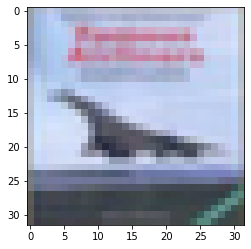

In [11]:
def show_val_image(idx):
    plt.imshow((val_images[idx].permute(1, 2, 0) * 0.229) + 0.485)
    plt.show()

interact(show_val_image, idx=widgets.IntSlider(min=0,max=50,step=1,value=0));

### build your own filter

Now lets build some convolutional filters !!
In lecture this week you learned about convolutional nerual networks. The key component of these networks are the convolutional filters that extract features from images. Of course these filters are typically learned by neural networks. The learned filters extract lots of high level information that is useful not only for the classification task, but they can also be used for other downstream tasks like object detection. This is why pretrained models are so powerful, training a model on image classification learns features that are general enough to be useful elsewhere.

To give you a sense for just how detailed and nuanced the learned features are, we wanted to give you a chance to extract your own features by hand designing convolutional filters. You will get to see just how well your features stack up against the features learned by a pretrained resnet.

in the cell below create at least 3 3x3 convolutional filters to apply to greyscale versions of these images. These filters should extract features from the images that you think might be useful for classifying between airplanes and automobiles. You are not necessarily restricted to using 3x3 filters, you may also design larger filters, but you are only required to do 3x3.

Define your filters as a 3x3 numpy array in the "filters" array, we did the first one for you to give you an examples.

The cell below will vizualise your filters and the features they extract on a set of images from the training set. To reduce the dimension of the extracted feautres we apply a 3x3 max pool with stride 3 after the convolution.

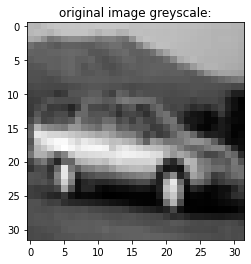

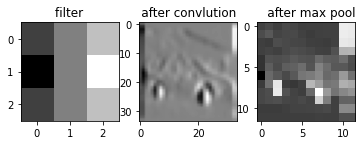

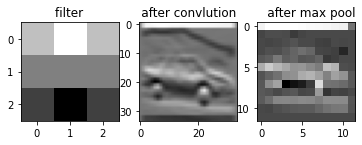

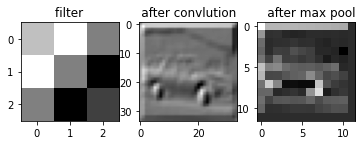

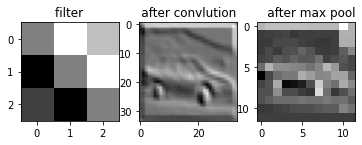

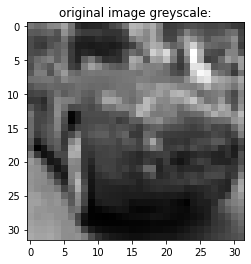

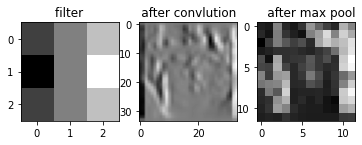

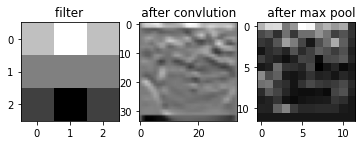

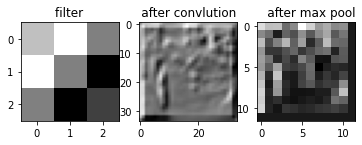

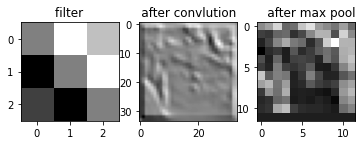

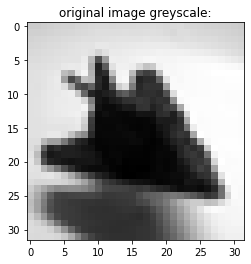

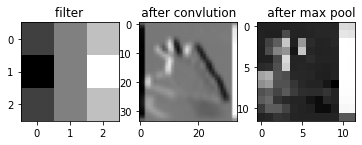

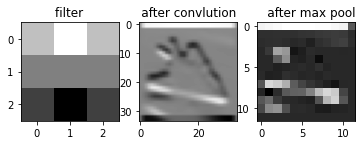

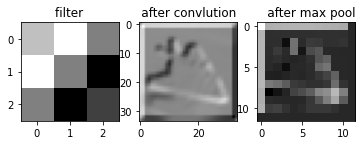

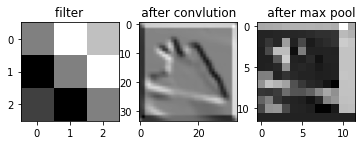

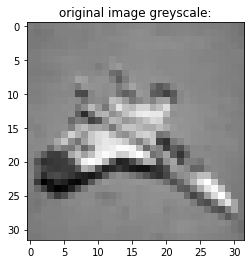

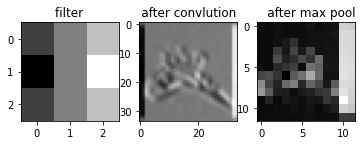

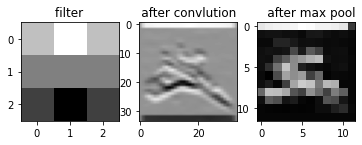

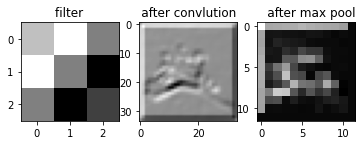

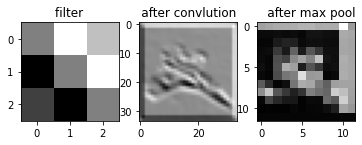

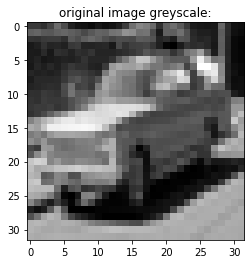

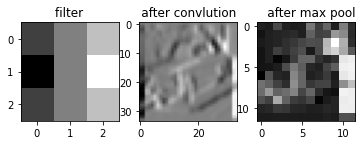

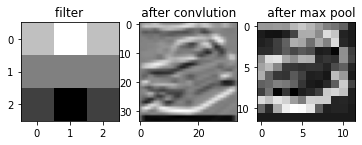

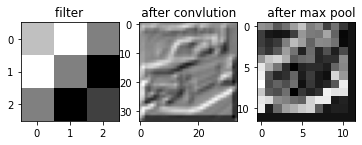

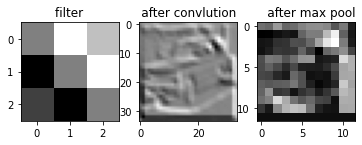

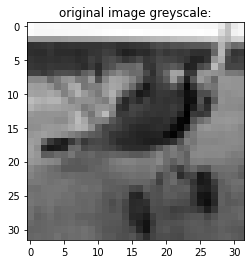

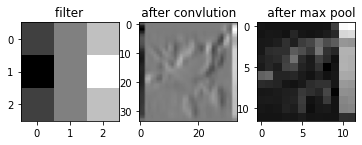

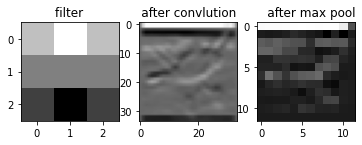

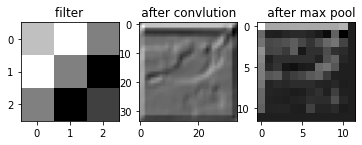

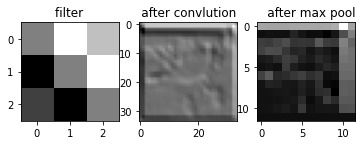

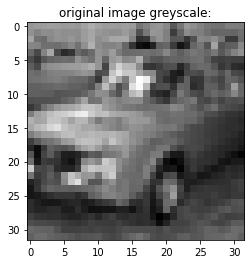

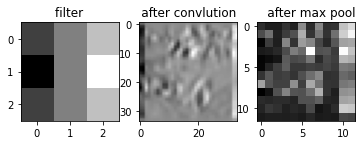

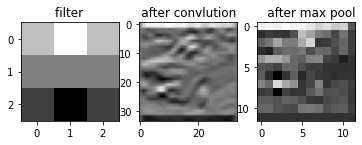

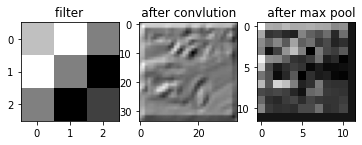

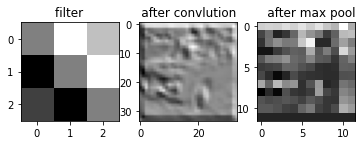

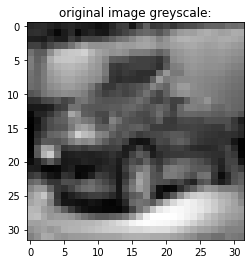

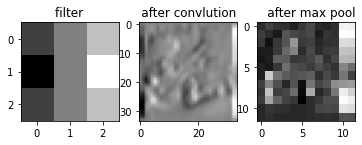

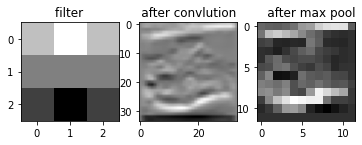

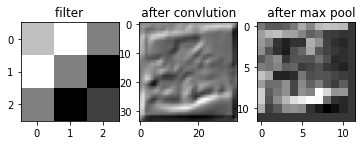

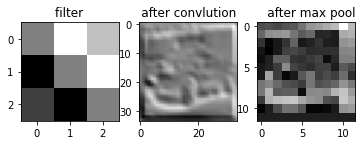

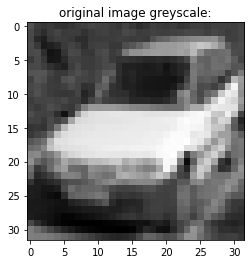

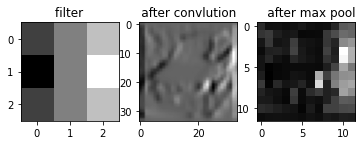

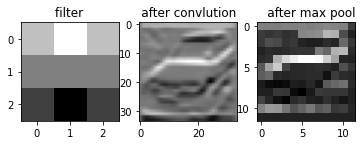

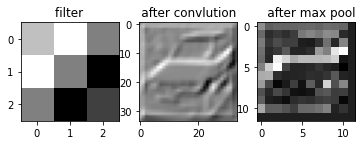

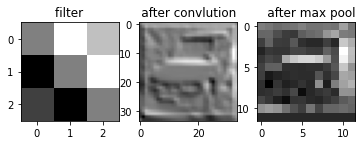

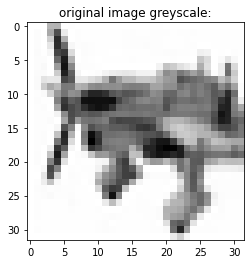

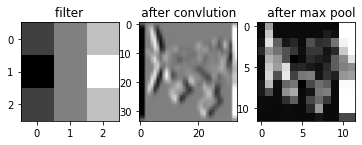

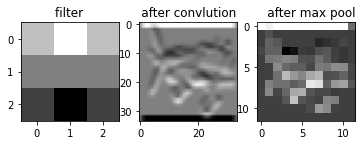

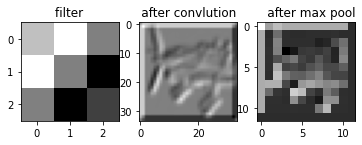

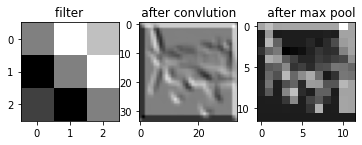

In [12]:
def convolve(image, filter_):
    return scipy.signal.convolve2d(image, filter_)

def maxpool(image, filter_size):
    return skimage.measure.block_reduce(image, filter_size, np.max)

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

filters = [np.array([[-5.0, 0.0, 5.0], [-10.0, 0.0, 10.0], [-5.0, 0.0, 5.0]]),
           np.array([[5.0, 10.0, 5.0], [0.0, 0.0, 0.0], [-5.0, -10.0, -5.0]]),
           np.array([[5.0, 10.0, 0.0], [10.0, 0.0, -10.0], [0.0, -10.0, -5.0]]),
           np.array([[0.0, 10.0, 5.0], [-10.0, 0.0, 10.0], [-5.0, -10.0, 0.0]])]

for i in range(10):
    norm_image = rgb2gray((train_images[i].permute(1, 2, 0) * 0.229) + 0.485)
    plt.title('original image greyscale:')
    plt.imshow(norm_image, cmap='gray')
    plt.show()

    for filter_ in filters:
        conved = convolve(norm_image, filter_)
        max_pooled = maxpool(conved, (3, 3))
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        ax1.imshow((filter_ - np.min(filter_)) / (np.max(filter_) - np.min(filter_)), cmap='gray')
        plt.title('filter               after convlution        after max pool', loc='right')
        ax2.imshow(conved, cmap='gray')
        ax3.imshow(max_pooled, cmap='gray')
        plt.show()


run the two cells below to extract your custom features from all the training and validation data, and to preprocess the data for training.

In [13]:
new_train_features = []
new_val_features = []
for i in range(len(train_images)):
    norm_image = rgb2gray((train_images[i].permute(1, 2, 0) * 0.229) + 0.485)
    new_features = []
    for filter_ in filters:
        conved = convolve(norm_image, filter_)
        max_pooled = maxpool(conved, (3, 3)).reshape(-1)
        new_features.extend(max_pooled.tolist())
    new_train_features.append(new_features)

for i in range(len(val_images)):
    norm_image = rgb2gray((val_images[i].permute(1, 2, 0) * 0.229) + 0.485)
    new_features = []
    for filter_ in filters:
        conved = convolve(norm_image, filter_)
        max_pooled = maxpool(conved, (3, 3)).reshape(-1)
        new_features.extend(max_pooled.tolist())
    new_val_features.append(new_features)

new_train_features = np.array(new_train_features)
new_val_features = np.array(new_val_features)

In [14]:
"""
x_train is the flattened raw pixel features
x_train_custom is your custom features concatenated with the flattened raw pixel features
x_train_pretrained are the features extracted from a pretrained resnset18 model
all arrays use the same y
for each of these arrays there is an analogous array for validation data
you should use these arrays to train classification models in the next three parts
"""

x_train = np.stack([x.reshape(-1).numpy() for x in train_images], axis=0)
x_train_custom = np.concatenate((x_train, new_train_features), axis=1)
x_val = np.stack([x.reshape(-1).numpy() for x in val_images], axis=0)
x_val_custom = np.concatenate((x_val, new_val_features), axis=1)

x_train_pretrained = np.stack(train_resnet_features, axis=0)
x_val_pretrained = np.stack(val_resnet_features, axis=0)
y_train = np.array(y_train)
y_val = np.array(y_val)

### classifying images with Ridge Regularized OLS
Here you will use ridge regression to cllassify between images. We cast binary classification into a regression problem by making the class 0 images y=-1 and the class 1 images y=1. We classify an image as 1 if its output is > 1 and -1 otherwise.

Train 3 OLS ridge classifiers. One on the raw image features, one on your handcrafted features + the raw imaage features, and lastly one on the pretrained model features.

For each you should report the training and validation accuracy and comment on the results in the text cell below. What ridge setting works best ? Which models perform best ? How do your features seem to stack up against the pretrained features, and how do they compare to the raw pixel features ?

Note: don't forget to rescale the y so that it is -1,1 instead of 0,1

In [15]:
def ols_ridge(x_train, y_train, x_val, y_val, lambda_):
    ols_w = ols_w = np.linalg.inv(x_train.T @ x_train + lambda_ * np.eye(x_train.shape[-1])) @ x_train.T @ y_train
    train_predictions = x_train @ ols_w
    train_acc = np.mean(np.sign(train_predictions) == y_train)
    val_predictions = x_val @ ols_w
    val_acc = np.mean(np.sign(val_predictions) == y_val)
    return train_acc, val_acc

y_train_ols = 2 * y_train - 1
y_val_ols = 2 * y_val - 1

train_acc, val_acc = ols_ridge(x_train, y_train_ols, x_val, y_val_ols, lambda_=0.01)
print('raw image:')
print('ols training accuracy: {acc}'.format(acc=train_acc))
print('ols validation accuracy: {acc}'.format(acc=val_acc))

train_acc, val_acc = ols_ridge(x_train_custom, y_train_ols, x_val_custom, y_val_ols, lambda_=0.01)
print('raw image + custom features:')
print('ols training accuracy: {acc}'.format(acc=train_acc))
print('ols validation accuracy: {acc}'.format(acc=val_acc))

train_acc, val_acc = ols_ridge(x_train_pretrained, y_train_ols, x_val_pretrained, y_val_ols, lambda_=0.01)
print('pretrained features:')
print('ols training accuracy: {acc}'.format(acc=train_acc))
print('ols validation accuracy: {acc}'.format(acc=val_acc))

raw image:
ols training accuracy: 0.9044
ols validation accuracy: 0.77
raw image + custom features:
ols training accuracy: 0.9676
ols validation accuracy: 0.8515
pretrained features:
ols training accuracy: 0.9998
ols validation accuracy: 0.9945


my handcrafted features outpreformed the raw pixel features by a good margin, but they don't touch the high validation accuracy of the pretrained features. I found a reletively small ridge setting worked fine: 0.01.

### classifying images with logistic regression
Obviously this is a classification problem, not a regression problem, so really it is a better idea to use logistic regression than OLS for this kind of task.

Train 3 logistic regression classifiers using the scikit LogisticRegression class. Report the same set of accuracies as the previous part. And comment on the results in the text cell below. What L2 penality worked best ? How did your custom features stack up against the pretrained model, and how did they compare to the raw pixel features ? Did logistic regression perform better or worse than OLS ?

In [16]:
def log_reg(x_train, y_train, x_val, y_val, lamb):
    log_reg = LogisticRegression(max_iter=1000, penalty='l2', C=float('inf') if lamb == 0.0 else 1.0/lamb)
    log_reg.fit(x_train, y_train)
    train_predictions = log_reg.predict(x_train)
    train_acc = np.mean(train_predictions == y_train)
    val_predictions = log_reg.predict(x_val)
    val_acc = np.mean(val_predictions == y_val)
    return train_acc, val_acc


train_acc, val_acc = log_reg(x_train, y_train, x_val, y_val, lamb=1.0)
print('raw image:')
print('logistic regression training accuracy: {acc}'.format(acc=train_acc))
print('logistic regression validation accuracy: {acc}'.format(acc=val_acc))

train_acc, val_acc = log_reg(x_train_custom, y_train, x_val_custom, y_val, lamb=1.0)
print('raw image + custom features:')
print('logistic regression training accuracy: {acc}'.format(acc=train_acc))
print('logistic regression validation accuracy: {acc}'.format(acc=val_acc))

train_acc, val_acc = log_reg(x_train_pretrained, y_train, x_val_pretrained, y_val, lamb=1.0)
print('pretrained features:')
print('logistic regression training accuracy: {acc}'.format(acc=train_acc))
print('logistic regression validation accuracy: {acc}'.format(acc=val_acc))

/home/arnav/Documents/project-t/env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


raw image:
logistic regression training accuracy: 0.9058
logistic regression validation accuracy: 0.7815
raw image + custom features:
logistic regression training accuracy: 0.9953
logistic regression validation accuracy: 0.8915
pretrained features:
logistic regression training accuracy: 1.0
logistic regression validation accuracy: 0.994


/home/arnav/Documents/project-t/env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


my custom features give a slightly higher performance in this logistic setting, but overall the relative ranking of the three feature sets is unchanged. I found an L2 penalty of 1 gave the highest validation accuracy.

### a second logistic regression implementation

In the previous part you used the SciKit implmentation of logistic regression to classify images. Here do the exact same thing as the previous part, except train it with stochastic gradient descent in pytorch. Report the same accuracy numbers. Your results should be similar to the previous part. You can use the weight_decay parameter in torch.optim.SGD to control L2 regularization. 

In [44]:
class BinLogReg (torch.nn.Module):
    def __init__(self, num_in):
        super(BinLogReg, self).__init__()
        self.linear = torch.nn.Linear(num_in, 1)
    
    def forward(self, x):
        return self.linear(x)

def train(x_train, y_train, x_val, y_val, lamb, steps, lr):
    torch_log_reg = BinLogReg(x_train.shape[-1])
    optim = torch.optim.SGD(torch_log_reg.parameters(), lr=lr, weight_decay=lamb)
    l = torch.nn.BCELoss()
    bs = 1024
    
    train_loss_log = []
    train_acc_log = []
    val_loss_log = []
    val_acc_log = []
    
    for step in range(steps):
        for i in range(0, len(x_train), bs):
            outputs = torch.sigmoid(torch_log_reg(x_train[i:i+bs, :])).squeeze()
            loss = l(outputs, y_train[i:i+bs].float())
            optim.zero_grad()
            loss.backward()
            optim.step()

        if step % 50 == 0 or step == steps - 1:
            train_outputs = torch_log_reg(x_train).squeeze()
            train_accuracy = np.mean(np.sign(train_outputs.detach().numpy()) == (2 * y_train.numpy() - 1))
            train_loss = l(torch.nn.functional.sigmoid(train_outputs), y_train.float()).item()
            
            train_loss_log.append(train_loss)
            train_acc_log.append(train_accuracy)

            val_outputs = torch_log_reg(x_val).squeeze()
            val_accuracy = np.mean(np.sign(val_outputs.detach().numpy()) == (2 * y_val.numpy() - 1))
            val_loss = l(torch.nn.functional.sigmoid(val_outputs), y_val.float()).item()
            
            val_loss_log.append(val_loss)
            val_acc_log.append(val_accuracy)
    
    loss_logs = {'train': train_loss_log, 'val' : val_loss_log}
    acc_logs = {'train': train_acc_log, 'val' : val_acc_log}
    
    return loss_logs, acc_logs

lamb = 0.5
steps = 1000
lr = 0.001

raw_loss, raw_acc = train(torch.tensor(x_train), torch.tensor(y_train), torch.tensor(x_val), torch.tensor(y_val), lamb, steps, lr)
custom_loss, custom_acc = train(torch.tensor(x_train_custom).float(), torch.tensor(y_train), torch.tensor(x_val_custom).float(), torch.tensor(y_val), lamb, steps, lr)
pre_loss, pre_acc = train(torch.tensor(x_train_pretrained).float(), torch.tensor(y_train), torch.tensor(x_val_pretrained).float(), torch.tensor(y_val), lamb, steps, lr)

In [45]:
def plot_logs(logs):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    # FYI using matplotlib is highly encouraged for analyzing your training and val history
    for i, log in enumerate(logs):
        
        # Adding train plot to graph
        ax[i].plot(list(range(0, len(log['train']))), log['train'], label="train")
        
        # Adding val plot to graph
        ax[i].plot(list(range(0, len(log['val']))), log['val'], label="val")
        
        # Making sure the legend is visible
        ax[i].legend()

    # Always label your graphs!!
    ax[0].set_xlabel("Model Loss")
    ax[1].set_xlabel("Model Accuracy");

Raw Image Features:


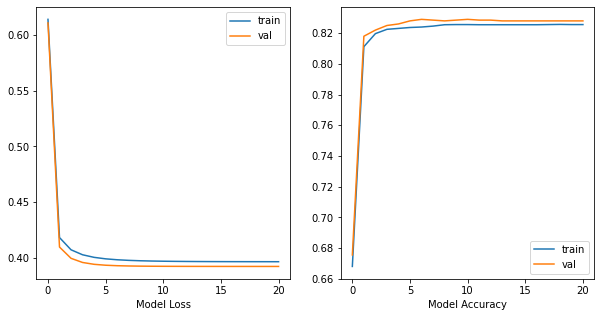

In [46]:
print("Raw Image Features:")
plot_logs([raw_loss, raw_acc])

Raw Image + Custom Features:


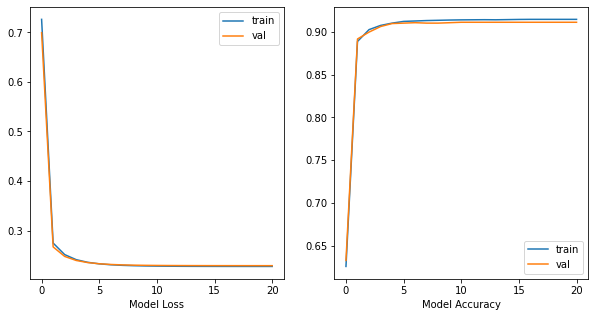

In [47]:
print("Raw Image + Custom Features:")
plot_logs([custom_loss, custom_acc])

Pre-trained Features:


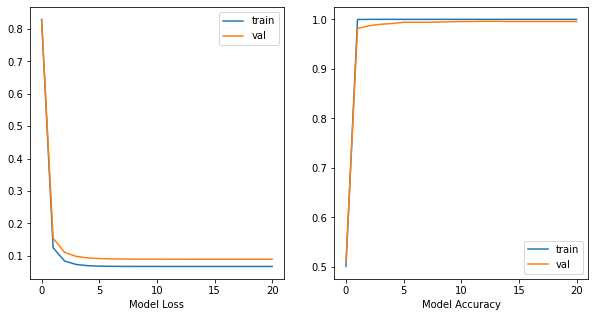

In [48]:
print("Pre-trained Features:")
plot_logs([pre_loss, pre_acc])

### feature visualization

In the following cells, run PCA on the raw pixel features from the training data, and project the validation features onto the two principal components with the largest singular values. Use these projections to visualize the data in two dimensions. Also plot the magnitude of top 200 singular values.

Repeat this for the other two sets of features in the next two cells, and then comment on your observations in the the text cell below. What differences do you see between the visualizations of the three featurizations ? Do these visualizations help explain any of the accuracy differences you saw in the previous parts ?

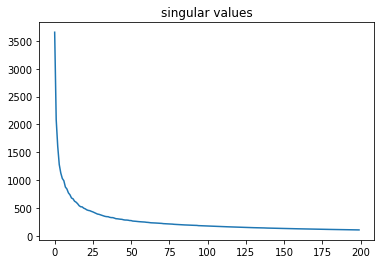

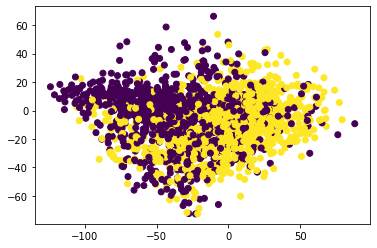

In [49]:
pca = PCA()
pca.fit(x_train)
plt.title('singular values')
plt.plot(pca.singular_values_[:200])
plt.show()

projected_features = x_val @ pca.components_[:2, :].T
x_, y_ = zip(*projected_features)
plt.scatter(x_, y_, c=y_val)
plt.show()

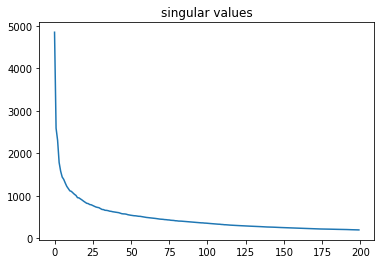

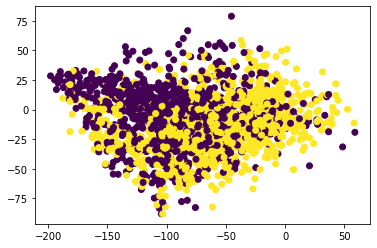

In [50]:
pca.fit(x_train_custom)
plt.title('singular values')
plt.plot(pca.singular_values_[:200])
plt.show()

projected_features = x_val_custom @ pca.components_[:2, :].T
x_, y_ = zip(*projected_features)
plt.scatter(x_, y_, c=y_val)
plt.show()

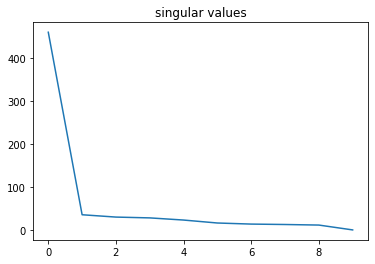

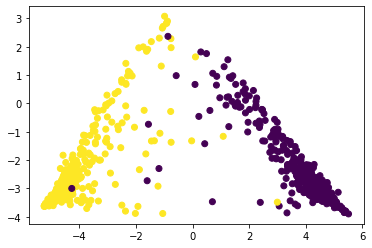

In [51]:
pca.fit(x_train_pretrained)
plt.title('singular values')
plt.plot(pca.singular_values_[:200])
plt.show()

projected_features = x_val_pretrained @ pca.components_[:2, :].T
x_, y_ = zip(*projected_features)
plt.scatter(x_, y_, c=y_val)
plt.show()

it seems that the raw features and the handcrafted features have similar PCA visualizations, but the pretrained features are categorically different. These features are almost already perfectly linearly separated in this 2d projection of the data, so celarly a lineary classifier is going to be able to almost perfeclty model this data with just a linear classifier on these features. The other two featurizations are mich noisier, explaining their poorer performance.

### How do pretrained models do it ?

Clearly these pretrained features are on another level. We'd be extreamly impressed if your handcrafted features  even came close to the pretrained features in accuracy. So why are these pretrained features so good ?

Typically pretrained models are trained on the ImageNet dataset. A massive and diverse dataset of color images from 1000 different classes. When these models are trained to classify on this massive dataset, they learn a set of very powerful image features.

This is the website for the image net dataset http://www.image-net.org/index. You can search for images by class on website. Explore the dataset and get a feel for the variety of images that these models are trained on.

### visualizing pretrained model filter
So you tried to come up with handcrafted filters, but they probably didn't outperform the pretrained models. So what filters do these pretrained models learn ? What is so much better about them ? Run the cell below to visualize the filters learned by a model pretrained on imagenet. These filters are just from the first layer of the network. After the first layer, we can't visualize the filters as easily because they take in more than 3 channels of input. But you can proabably guess that these deeper filters learn to extract even more complex features.

Report your observations in the text cell below. What kinds of features do these filters seem to be extracting ? How do they compare to your handcrafted filters ?

In [6]:
image_net_model = models.resnet18(pretrained=True)

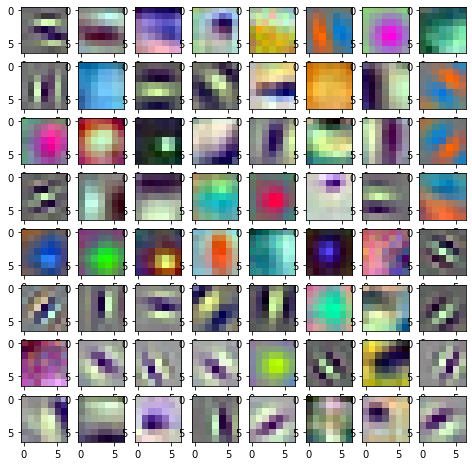

In [7]:
fig, axs = plt.subplots(8, 8, figsize=(8, 8))
for i in range(image_net_model.conv1.weight.shape[0]):
    filter_ = image_net_model.conv1.weight[i].permute(1, 2, 0).clone().detach().numpy()
    filter_ = (filter_ - np.min(filter_)) / (np.max(filter_) - np.min(filter_))
    axs[i // 8, i % 8].imshow(filter_)
plt.show()

It seems like there are some edge detectors at different angles and focused on different colors. There also seem to be some circle detectors and noisy texture detectors. These filters are significantly more detailed than what I crafted by hand, there is no way I could have made filters this detailed myself.

### optional challenge for bonus points

If you can get your hand crafted features to exceed 90% validation accuracy on your SGD implementation of logistic regression, you will recieve 1 bonus point. If you exceed 92.5% you will recieve 2 bonus points. And if you exceed 95% you will recieve 3 bonus points.